In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<div align='right'>_last updated 9/10/2018 3:20pm_</div>

### Table of contents:
Same site, same method<br>
[DIA vs DIA](#dia-dia)<br>
[SRM vs SRM](#srm-srm)<br><br>
Same site, different methods<br>
[DIA vs SRM-A](#dia-srmA)<br>
[SWATH vs SRM-B](#swath-srmB)<br><br>
Different sites, same method<br>
[DIA vs SWATH](#dia-swath)<br>
[SRM-A vs SRM-B](#srmA-srmB)<br><br>
Different sites, different methods<br>
[DIA vs SRM-B](#dia-srmB)<br>
[SWATH v SRM-A](#swath-srmA)<br><br>
Conclusions<br>
[Perpendicular offsets barchart](#offsets)<br><br>



### Background.

I used the code below to produce the figures that appear in the manuscript (Figure 2, Supplemental Figure 1, and Supplemental Figure 2). To run the code yourself, you'll have to first download this IPython notebook, and then also download the data. You can save the DIA and SRM quantitative matrices from the tabs in Supplemental Table 2, or you can download the \*.csv files directly from the BitBucket page here: https://bitbucket.org/lkpino/single-point_calibration/downloads/ . You'll also need the data from Selevsek *et al*, which I have details on below.

If you'd like to reanalyze the raw files, you can find them on Chorus (Project 1491: Single-point Calibration). The Skyline documents will be available on Panorama soon.

In [6]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

%matplotlib inline

sys.stderr.write('Imported required packages.')

Imported required packages.

In [7]:
# takes as input a skyline dataframe, calibrates the "shock" values to "calibrant" values
def format_skyline(df):

    ## TODO SWAP 'PEPTIDE MODIFIED SEQUENCE' FOR 'PEPTIDE SEQUENCE'
    # format the dataframe with a column for precursors, and drop some unnecessary 
    df['precursor'] = df['Peptide Sequence'].map(str) + "_" + df['Precursor Charge'].map(str)
    df = df[['Protein Name', 'precursor', 'Total Area Fragment', 'SampleGroup']]
    df = df.drop_duplicates()
   
    return df

# calculates the ratio of the experimental sample to the reference sample and multiplies by ghaemmaghami values
def calibrate_df(df, sample, reference, quantcolumn='Total Area Fragment', level='precursor'):
    
    # quantcolumn: 'Total Area Fragment', never anything else?
    # level options: 'Protein Name' or 'precursor'

    calibrated_df = df.groupby([level, 'SampleGroup'], as_index=False)[quantcolumn].mean()
    #print selevsek_quant.head()
    calibrated_df = pd.pivot_table(calibrated_df, index=level, columns='SampleGroup', values=quantcolumn)
    calibrated_df['calibrated area'] = calibrated_df[sample] / calibrated_df[reference]
    #print selevsek_quant.head()
    calibrated_df.drop([sample, reference], axis=1, inplace=True)
    #print selevsek_quant.head()

    # melt the wide dataframe into a long dataframe
    # this is necessary for merging the calibrated areas back with the original data
    calibrated_df = calibrated_df.unstack().reset_index()
    #print selevsek_quant.head()
    calibrated_df.columns = ['variable', level, 'calibrated area']
    calibrated_df = calibrated_df.drop(['variable'], axis=1)
    #print selevsek_quant.head()
    calibrated_df = pd.melt(calibrated_df, id_vars=[level], value_vars=['calibrated area'])
    #print selevsek_quant.head()

    # format the long dataframe so that it can be merged back with the original dataframe
    # specifically, clean up column names
    calibrated_df = calibrated_df.drop(['variable'], axis=1)
    #print selevsek_quant.head()
    calibrated_df.columns = [level, 'calibrated area']

    # merge the calibrated values back into the dataframe
    calibrated_df = pd.merge(df, calibrated_df, how='left', on=[level])
    #print calibrated_df.head()

    # merge protein copies into dataframe
    calibrated_df = calibrated_df.rename(columns = {'protein_name':'Protein Name'})
    calibrated_df = pd.merge(calibrated_df, ghaemma_df, how='left', on=['Protein Name'])
    calibrated_df['protein_copiespercell'] = calibrated_df['calibrated area']*pd.to_numeric(calibrated_df['Protein Molecules/Cell'])
    calibrated_df = calibrated_df.drop_duplicates()
    #print calibrated_df.head()
    
    return calibrated_df

## merges two dataframes together on their shared precursors
def joint_pivot_table(df1, df2, quantvalue):
    
    # quantvalue: 'Total Area Fragment' or 'calibrated area'
    
    if 'Protein Name' not in list(df1):
        sys.stderr.write("Renaming 'protein_name' columns to 'Protein Name' (df1)\n")
        df1=df1.rename(columns = {'protein_name':'Protein Name'})
    if 'Protein Name' not in list(df2):
        sys.stderr.write("Renaming 'protein_name' columns to 'Protein Name' (df2)\n")
        df2=df2.rename(columns = {'protein_name':'Protein Name'})
    
    # average peptides/transitions to protein quant
    df1 = df1.groupby(['precursor', 'SampleGroup'], as_index=False)[quantvalue].mean()
    df2 = df2.groupby(['precursor', 'SampleGroup'], as_index=False)[quantvalue].mean()

    # pivot both dataframes so that proteins are rows, samplegroups are columns, and quants are values
    df1 = pd.pivot_table(df1, index='precursor', columns='SampleGroup', values=quantvalue).unstack().reset_index()
    df1.columns = ['SampleGroup', 'precursor', quantvalue]
    #print df1.head()

    df2 = pd.pivot_table(df2, index='precursor', columns='SampleGroup', values=quantvalue).unstack().reset_index()
    df2.columns = ['SampleGroup', 'precursor', quantvalue]
    #print df2.head()

    shared_df = df1.append(df2)
    shared_df = pd.pivot_table(shared_df, index='precursor', columns='SampleGroup', values=quantvalue)
    shared_df = np.log10(shared_df)
    shared_df = shared_df.replace([np.inf, -np.inf], np.nan)
    shared_df = shared_df.dropna()

    print "Finite precursors shared: %d" % len(shared_df)

    return shared_df

## plots two vectors against each other
def plot_correlation(x, y, xlabel, ylabel, ptalpha=0.5):
    
    # define three sizes for everything in the figure (axes, etc)
    SMALL_SIZE = 22
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 26

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    # make a scatterplot of the data x vs y
    fig, ax = plt.subplots()
    ax.scatter(x, y, color='black', alpha=ptalpha, s=30)

    # use the same axis scale for all plots for uniformity
    lims = [1,9]

    # add a red-colored line of equality, y=x
    ax.plot(lims, lims, 'k-', alpha=0.75, color='red', zorder=0)
    
    # now plot both axes against each other
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    # force axis ticks to be integers so the plot is prettier
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # hide the right and top spines for prettier plot
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # add labels for the two axes based on function inputs
    fig.suptitle('', fontsize=16)  # no title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # adjust the borders to cut off excess whitespace and make room for xaxis label
    plt.tight_layout()

    return plt

## calculates the distance from a point to a y=x diagonal line
def perpendicular_offset(x0,y0):
    
    # define a y=x line to calculate the distance from
    # where y_1 = x_1 = (any value) and y_2 = x_2 = (any other value)
    y_1 = 0
    x_1 = 0
    y_2 = 10
    x_2 = 10
    
    # generic formula for distance from a point to a line
    distance = abs(((y_2-y_1)*x0)-((x_2-x_1)*y0)+(x_2*y_1)-(y_2*x_1))/np.sqrt(((y_2-y_1)**2)+((x_2-x_1)**2))

    return distance


sys.stderr.write('Read in all functions.')

Read in all functions.

### Preparing the data

This work uses datasets collected at two laboratory sites and using multiple acquisition methods: two sample preparation replicates collected both by DIA and SRM (four total data sets), and another set of samples collected by Selevsek 2015 by both SWATH and SRM. Additionally, we're use the Ghaemmaghami 2003 protein molecules/cell quantities as a biological unit multiplier.

Here, we're cleaning each of the MS data sets so that they all match the same format. We're also calibrating each data set to its resepective reference material. At the end of this chunk of code, we have twelve data sets: six data sets with the "raw" Total Area Fragment quantifications and six parallel data sets with the calibrated Protein Molecules/Cell values.

In [10]:
project_dir = "G:/My Drive/00_UW_GS/proj/single-point_calibration"

##
## set up the Ghaemmaghami 2003 data to use as unit multipliers
##

# read in the ghaemmaghami file from their supplemental data table
ghaemma_file = os.path.join(project_dir, 
                            "./data/2003 Ghaemmaghami Weissman - Global analysis of protein expression in yeast SUPPLEMENTAL DATA.csv")
ghaemma_df = pd.read_csv(ghaemma_file, sep=None, engine="python")

# rename the ORF column to "Protein Name" and remove all but protein names and copies/cell information
ghaemma_df.rename(columns={'ORF': 'Protein Name'}, inplace=True)
ghaemma_df = ghaemma_df[['Protein Name','Protein Molecules/Cell']]

# remove nan from the ghaemma_df
nonnumeric_ghaemma_values = ['-','%','#']
ghaemma_df = ghaemma_df[~ghaemma_df['Protein Molecules/Cell'].isin(nonnumeric_ghaemma_values)]


## 
## read in the DIA data (sample prep rep 1 and sample prep rep 2)
##

dia_file = os.path.join(project_dir, 
                             "./data/final/osmoticshock_dia_site-a.csv")
dia_df = pd.read_csv(dia_file, sep=None, engine="python")
# split the DIA data into two data frames, one for each of the sample prep replicates
dia_1_df = format_skyline(dia_df[(dia_df['SampleGroup'] == 'reference_dia1') |\
                                 (dia_df['SampleGroup'] == 'sample_dia1')])
dia_2_df = format_skyline(dia_df[(dia_df['SampleGroup'] == 'reference_dia2') |\
                                 (dia_df['SampleGroup'] == 'sample_dia2')])
# calibrate each of the two DIA datasets to their respective references
calibrated_dia_1_df = calibrate_df(dia_1_df, sample='sample_dia1', reference='reference_dia1')
calibrated_dia_2_df = calibrate_df(dia_2_df, sample='sample_dia2', reference='reference_dia2')
#print calibrated_dia_1_df.head()


## 
## read in the SRM data (sample prep rep 1 and sample prep rep 2, same samples from DIA)
##

srmA_file = os.path.join(project_dir, 
                             "./data/final/osmoticshock_srm_site-a.csv")
srmA_df = pd.read_csv(srmA_file, sep=None, engine="python")
# split the SRM data into two data frames, one for each of the sample prep replicates
srmA_1_df = format_skyline(srmA_df[(srmA_df['SampleGroup'] == 'reference_srmA1') |\
                                   (srmA_df['SampleGroup'] == 'sample_srmA1')])
srmA_2_df = format_skyline(srmA_df[(srmA_df['SampleGroup'] == 'reference_srmA2') |\
                                   (srmA_df['SampleGroup'] == 'sample_srmA2')])
# calibrate each of the two DIA datasets to their respective references
calibrated_srmA_1_df = calibrate_df(srmA_1_df, sample='sample_srmA1', reference='reference_srmA1')
calibrated_srmA_2_df = calibrate_df(srmA_2_df, sample='sample_srmA2', reference='reference_srmA2')
#print calibrated_srmA_1_df.head()


##
## read in the swath data from selevsek 2015 supplement
##

swath_file = os.path.join(project_dir,
                            "./data/Selevsek2015_SupplementalData1/SWATH - SUBMITTED/Input/Yeast__18timepoints_FeatureRefinement_InputData_lasttimepoint.csv")
swath_df = pd.read_csv(swath_file, sep=None, engine="python")
# rename columns to match our data's convention
swath_df = swath_df.rename(columns = {'PROTEIN': 'Protein Name', 
                                      'PEPTIDE': 'precursor', 
                                      'INTENSITY':"Total Area Fragment"})
# format the SampleGroup values for future reference
swath_df['SampleGroup'] = swath_df['SampleGroup']+"_swath"
# calibrate the signals to their respective references
calibrated_swath_df = calibrate_df(swath_df, sample='shock_swath', reference='calibrant_swath')


##
## read in the srm data from selevsek 2015 supplement
##

srmB_file = os.path.join(project_dir, 
                         "./data/Selevsek2015_SupplementalData1/SRM - SUBMITTED/data/InputSRMstats_SRM_20120723_addedsamplegroups.csv")
srmB_df = pd.read_csv(srmB_file, sep=None, engine="python")
srmB_df['precursor'] = srmB_df['PeptideSequence'].map(str)+"_"+srmB_df['PrecursorCharge'].map(str)
srmB_df['SampleGroup'] = srmB_df['SampleGroup'] + "_srmB"
calibrated_srmB_df = calibrate_df(srmB_df, sample='shock_srmB', reference='calibrant_srmB')

sys.stderr.write('Read in all required data.')

C:\Users\Lindsay\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Read in all required data.

<a id = 'dia-dia'></a>
## DIA-1 v DIA-2: SAME SITE, SAME METHOD 

This comparison illustrates a reduced "5x5" style experiment, where the same operator (myself) prepared aliquots of the same cell harvest on two different days. Then, I acquired each of those two sample preps with DIA. The variation we might see here is due to the sample preparation and, to a lesser extent, the measurement reproducibility of the acquisition method.

Correlation of uncalibrated DIA-1 vs DIA-2
Finite precursors shared: 29907


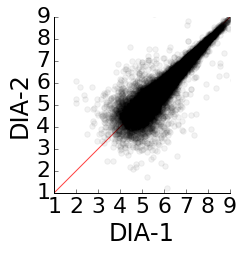

In [11]:
# how well do the Total Area Fragment correlate with each other before calibration?
sys.stdout.write("Correlation of uncalibrated DIA-1 vs DIA-2\n")
uncalibrated_dia1dia2_df = joint_pivot_table(dia_1_df, dia_2_df, 'Total Area Fragment')
dia1dia2_uncal = plot_correlation(uncalibrated_dia1dia2_df['sample_dia1'], uncalibrated_dia1dia2_df['sample_dia2'], 
                                  'DIA-1', 'DIA-2', ptalpha=0.05)
#dia1dia2_uncal.savefig(os.path.join(project_dir, "osmotic_shock/results/dia1dia2_uncal.png"))

Correlation of the calibrated day1 day2 values.
Finite precursors shared: 25547


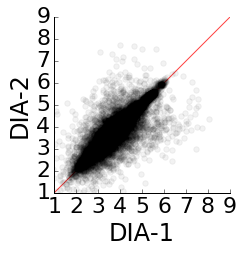

In [12]:
# how well do the areas correlate after calibration?
sys.stdout.write("Correlation of the calibrated day1 day2 values.\n")
calibrated_dia1dia2_df = joint_pivot_table(calibrated_dia_1_df, calibrated_dia_2_df, 'protein_copiespercell')
dia1dia2_cal = plot_correlation(calibrated_dia1dia2_df['sample_dia1'], calibrated_dia1dia2_df['sample_dia2'], 
                                'DIA-1', 'DIA-2', ptalpha=0.05)
#dia1dia2_cal.savefig(os.path.join(project_dir, "osmotic_shock/results/dia1dia2_cal.png"))

### Correlation coefficient comparison for uncalibrated and calibrated
We calculate the Pearson product-moment correlation coefficient between the DIA-1 data and the DIA-2 data, first uncalibrated and then calibrated values. We might not expect to see much of a change in the correlation coefficient values based on what we see visually in the plots above.

In [39]:
# correlation coefficient
uncal_corrcoef_diadia = np.corrcoef(uncalibrated_dia1dia2_df['sample_dia1'], 
                             uncalibrated_dia1dia2_df['sample_dia2'])
cal_corrcoef_diadia = np.corrcoef(calibrated_dia1dia2_df['sample_dia1'], 
                           calibrated_dia1dia2_df['sample_dia2'])

print "Uncalibrated DIA-1 v DIA-2 correlation coefficient: %f" % (uncal_corrcoef_diadia[0,1])
print "Calibrated DIA-1 v DIA-2 correlation coefficient: %f" % (cal_corrcoef_diadia[0,1])

Uncalibrated DIA-1 v DIA-2 correlation coefficient: 0.925348
Calibrated DIA-1 v DIA-2 correlation coefficient: 0.868569


<a id = 'srm-srm'></a>
## SRM-1 v SRM-2: SAME SITE, SAME METHOD 

Similar to the DIA vs DIA above, this comparison acquires two sample preps with SRM. For the SRM method, we picked 140 targets based on the DIA detections from the same samples, spanning the range of signal response. We shouldn't expect to see much different in these plots compared to the DIA-1/DIA-2 plots above, because these are the same samples as in those plots. These SRM-1/SRM-2 plots should just have less data points.

Correlation of uncalibrated SRM day1 vs SRM day2
Finite precursors shared: 140


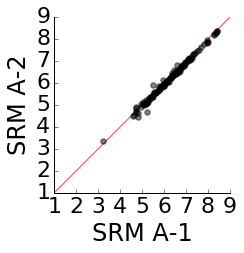

In [13]:
# how well do the Total Area Fragment correlate with each other before calibration?
sys.stdout.write("Correlation of uncalibrated SRM day1 vs SRM day2\n")
uncalibrated_srmAsrmA_df = joint_pivot_table(srmA_1_df, srmA_2_df, 'Total Area Fragment')
srmAsrmA_uncal = plot_correlation(uncalibrated_srmAsrmA_df['sample_srmA1'], uncalibrated_srmAsrmA_df['sample_srmA2'], 
                                'SRM A-1', 'SRM A-2', ptalpha=0.5)
#srmAsrmA_uncal.savefig(os.path.join(project_dir, "osmotic_shock/results/srmAsrmA_uncal.png"))

Correlation of the calibrated day1 day2 SRM values.
Finite precursors shared: 119


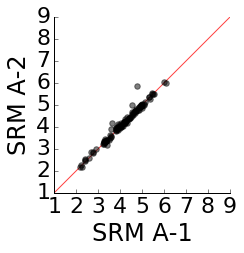

In [14]:
# how well do the areas correlate after calibration?
sys.stdout.write("Correlation of the calibrated day1 day2 SRM values.\n")
calibrated_srmAsrmA_df = joint_pivot_table(calibrated_srmA_1_df, calibrated_srmA_2_df, 'protein_copiespercell')
srmAsrmA_cal = plot_correlation(calibrated_srmAsrmA_df['sample_srmA1'], calibrated_srmAsrmA_df['sample_srmA2'], 
                                'SRM A-1', 'SRM A-2', ptalpha=0.5)
#srmAsrmA_cal.savefig(os.path.join(project_dir, "osmotic_shock/results/srmAsrmA_cal.png"))

<a id = 'dia-srmA'></a>
## DIA v SRM-A: SAME SITE, DIFFERENT METHOD 

Things get a little more interesting when we compare peptide quantifications of the same sample acquired by DIA versus acquired by SRM. Since these are the same sample acquired on two platforms, the variation we see here is due to the instrument/method.

Precursors shared between DIA and SRM (uncalibrated):
Finite precursors shared: 117


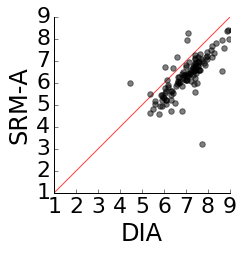

In [15]:
sys.stdout.write("Precursors shared between DIA and SRM (uncalibrated):\n")
uncalibrated_diaAsrmA_df = joint_pivot_table(dia_1_df, srmA_1_df, 'Total Area Fragment')
diaAsrmA_uncal = plot_correlation(uncalibrated_diaAsrmA_df['sample_dia1'], uncalibrated_diaAsrmA_df['sample_srmA1'], 
                                  'DIA', 'SRM-A', ptalpha=0.5)
#diaAsrmA_uncal.savefig(os.path.join(project_dir, "osmotic_shock/results/diaAsrmA_uncal.png"))

Precursors shared between DIA and SRM (calibrated, so requires a Ghaemmaghami 2003 measurement):
Finite precursors shared: 98


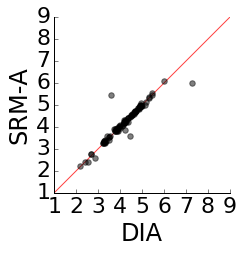

In [16]:
sys.stdout.write("Precursors shared between DIA and SRM (calibrated, so requires a Ghaemmaghami 2003 measurement):\n")
calibrated_diaAsrmA_df = joint_pivot_table(calibrated_dia_1_df, calibrated_srmA_1_df, 'protein_copiespercell')
diaAsrmA_cal = plot_correlation(calibrated_diaAsrmA_df['sample_dia1'], calibrated_diaAsrmA_df['sample_srmA1'], 
                                'DIA', 'SRM-A', ptalpha=0.5)
#diaAsrmA_cal.savefig(os.path.join(project_dir, "osmotic_shock/results/diaAsrmA_cal.png"))

<a id = 'swath-srmB'></a>
## SWATH v SRM-B: SAME SITE, DIFFERENT METHOD 

I compared the two Selevsek 2015 data sets (SWATH and SRM) against each other. I would expect these to look highly comparable, because the SRM targets were selected from the SWATH targets, and the exact same reference sample (presumably they used the same sample or an aliquot from the same!) was used in both. I seem to vaguely recall reading in Selevsek 2015 that the data was collected at different times, so maybe that's not actually the case.

I used the data that was used directly in Selevsek 2015, without reanalyzing the raw files. I downloaded the supplemental data from Selevsek 2015. To download this yourself, go to this site (http://www.mcponline.org/content/14/3/739/suppl/DC1) and download the Supplemental Data 1 directory (DOWNLOAD WARNING: http://www.mcponline.org/content/suppl/2015/01/05/M113.035550.DC1/mcp.M113.035550-11.zip). Inside this directory, you'll find all the data that Selevsek et al used in their analyses.

*Specifics on the Selevsek 2015 SWATH data: From the `SWATH - SUBMITTED/Input/Yeast__18timepoints_FeatureRefinement_InputData1` data file, I changed the "GROUP" column name to "SampleGroup", and changed the coded sample groups to named sample groups ('calibrant' for the first timepoint, and 'shock' for the last timepoint). I removed all timepoints except for the first and last timepoint, because I would not be using the other timepoints for this analysis. Additionally, this brings the file size down 66%, which is helpful for using Juypter notebooks! All other manipulations to the data file are performed below.*

*Specifics on the Selevsek 2015 SRM data set: From the `SRM - SUBMITTED\data\InputSRMstats_SRM_20120723` data file, again I changed the "Condition" column to be named "SampleGroup" and removed all timepoints except for the first and last timepoint.*

Correlation of the uncalibrated SRM-B versus SWATH values.
Finite precursors shared: 69


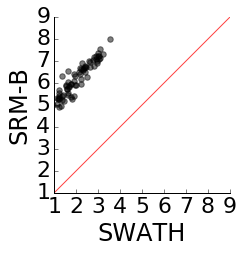

In [17]:
sys.stdout.write("Correlation of the uncalibrated SRM-B versus SWATH values.\n")
swathsrmB_uncalibrated_df = joint_pivot_table(swath_df, srmB_df, 'Total Area Fragment')
swathsrmB_uncal = plot_correlation(swathsrmB_uncalibrated_df['shock_swath'], swathsrmB_uncalibrated_df['shock_srmB'], 
                                   'SWATH', 'SRM-B')
#swathsrmB_uncal.savefig(os.path.join(project_dir, "osmotic_shock/results/swathsrmB_uncal.png"))

Correlation of the calibrated SRM versus SWATH values.
Finite precursors shared: 59


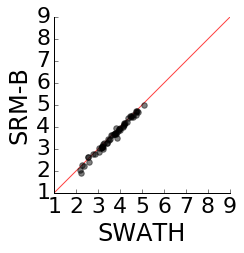

In [18]:
sys.stdout.write("Correlation of the calibrated SRM versus SWATH values.\n")
swathsrmB_calibrated_df = joint_pivot_table(calibrated_swath_df, calibrated_srmB_df, 'protein_copiespercell')
swathsrmB_cal = plot_correlation(swathsrmB_calibrated_df['shock_swath'], swathsrmB_calibrated_df['shock_srmB'], 
                                 'SWATH', 'SRM-B')
#swathsrmB_cal.savefig(os.path.join(project_dir, "osmotic_shock/results/swathsrmB_cal.png"))

<a id = 'dia-swath'></a>
## DIA v SWATH: DIFFERENT SITE, SAME(-ISH) METHOD 

This comparison illustrates the issues of **study hetereogeneity**, which just means that values from different publications are comparable. For most quantitative mass spectrometry experiments, this isn't the case, which means we can't usually reuse quantitative data across experiments. Being able to combine experiments into larger datasets is valuable for meta-analysis, for large-scale experiments (across many batches, or even many sites), and for longitudinal studies. 

To demonstrate the ability of single-point calibration to harmonize data, I'm comparing the DIA quantifications collected at UW in 2017 to the SWATH quantifications collected by Selevsek 2015. We should expect to see little agreement between the values measured at one site on a Q-TOF and the values measured at a different site on an Orbitrap. However, if single-point calibration harmonizes the quantifications, the we'd expect the data to be more comparable.

Correlation of the uncalibrated DIA versus SWATH values.
Finite precursors shared: 9932


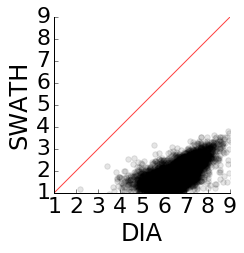

In [19]:
sys.stdout.write("Correlation of the uncalibrated DIA versus SWATH values.\n")
uncalibrated_diaswath_df = joint_pivot_table(dia_1_df, swath_df, 'Total Area Fragment')
diaswath_uncal = plot_correlation(uncalibrated_diaswath_df['sample_dia1'], uncalibrated_diaswath_df['shock_swath'], 
                                  'DIA', 'SWATH', ptalpha=0.1)
#diaswath_uncal.savefig(os.path.join(project_dir, "osmotic_shock/results/diaswath_uncal.png"))

Correlation of the calibrated DIA versus SWATH values.
Finite precursors shared: 8503


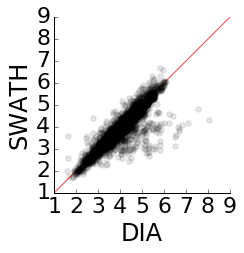

In [20]:
sys.stdout.write("Correlation of the calibrated DIA versus SWATH values.\n")
calibrated_diaswath_df = joint_pivot_table(calibrated_dia_1_df, calibrated_swath_df, 'protein_copiespercell')
diaswath_cal = plot_correlation(calibrated_diaswath_df['sample_dia1'], calibrated_diaswath_df['shock_swath'], 
                                'DIA', 'SWATH', ptalpha=0.1)
#diaswath_cal.savefig(os.path.join(project_dir, "osmotic_shock/results/diaswath_cal.png"))

### Correlation coefficient comparison for uncalibrated and calibrated
We calculate the Pearson product-moment correlation coefficient between the DIA data and the SWATH data, first uncalibrated and then calibrated values. 

In [38]:
# correlation coefficient
uncal_corrcoef = np.corrcoef(uncalibrated_diaswath_df['sample_dia1'], 
                             uncalibrated_diaswath_df['shock_swath'])
cal_corrcoef = np.corrcoef(calibrated_diaswath_df['sample_dia1'], 
                           calibrated_diaswath_df['shock_swath'])

print "Uncalibrated DIA v SWATH correlation coefficient: %f" % (uncal_corrcoef[0,1])
print "Calibrated DIA v SWATH correlation coefficient: %f" % (cal_corrcoef[0,1])

Uncalibrated DIA v SWATH correlation coefficient: 0.632132
Calibrated DIA v SWATH correlation coefficient: 0.921955


<a id = 'srmA-srmB'></a>
## SRM-A v SRM-B: DIFFERENT SITE, SAME(-ISH) METHOD 

The current iteration of SRM data doesn't share many targets with the Selevsek SRM. While the improvement from calibration looks good, there's just not enough data to really make a strong comparison. I'll ask Eric to collect the Selevsek target list so that we can compare their SRM with our SRM and have enough data to draw a conclusion.


Correlation of the uncalibrated SRM-A versus SRM-B values.
Finite precursors shared: 13


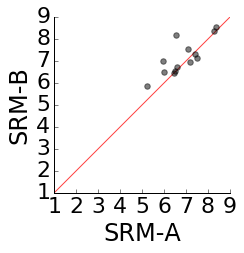

In [22]:
sys.stdout.write("Correlation of the uncalibrated SRM-A versus SRM-B values.\n")
srmAsrmB_uncalibrated_df = joint_pivot_table(srmA_1_df, srmB_df, 'Total Area Fragment')
srmAsrmB_uncal = plot_correlation(srmAsrmB_uncalibrated_df['sample_srmA1'], srmAsrmB_uncalibrated_df['shock_srmB'], 
                                  'SRM-A', 'SRM-B')
#srmAsrmB_uncal.savefig(os.path.join(project_dir, "osmotic_shock/results/srmAsrmB_uncal.png"))

Correlation of the calibrated SRM-A versus SRM-B values.
Finite precursors shared: 11


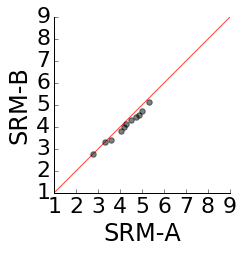

In [23]:
sys.stdout.write("Correlation of the calibrated SRM-A versus SRM-B values.\n")
srmAsrmB_calibrated_df = joint_pivot_table(calibrated_srmA_1_df, calibrated_srmB_df, 'protein_copiespercell')
srmAsrmB_cal = plot_correlation(srmAsrmB_calibrated_df['sample_srmA1'], srmAsrmB_calibrated_df['shock_srmB'], 
                                'SRM-A', 'SRM-B')
#srmAsrmB_cal.savefig(os.path.join(project_dir, "osmotic_shock/results/srmAsrmB_cal.png"))

<a id = 'dia-srmB'></a>
## DIA v SRM-B: DIFFERENT SITE, DIFFERENT METHOD 

The most disparate comparison we can make is two different sites and two different methods. This first comparison will be DIA from Site A (UW) with the SRM from Site B (Selevsek *et al*). The SRM targets here were selected based on the Selevsek *et al* SWATH data, so we shouldn't expect to have detected all these SRM peptides in the DIA data.

Correlation of the uncalibrated DIA versus SRM-B values.
Finite precursors shared: 56


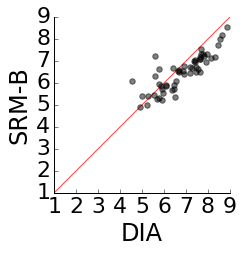

In [24]:
sys.stdout.write("Correlation of the uncalibrated DIA versus SRM-B values.\n")
uncalibrated_diasrmB_df = joint_pivot_table(dia_1_df, srmB_df, 'Total Area Fragment')
diasrmB_uncal = plot_correlation(uncalibrated_diasrmB_df['sample_dia1'], uncalibrated_diasrmB_df['shock_srmB'], 
                                 'DIA', 'SRM-B')
#diasrmB_uncal.savefig(os.path.join(project_dir, "osmotic_shock/results/diasrmB_uncal.png"))

Correlation of the calibrated DIA versus SRM values.
Finite precursors shared: 52


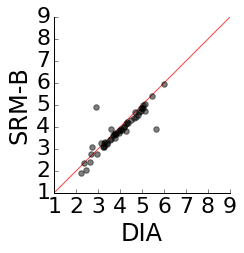

In [25]:
sys.stdout.write("Correlation of the calibrated DIA versus SRM values.\n")
calibrated_diasrmB_df = joint_pivot_table(calibrated_dia_1_df, calibrated_srmB_df, 'protein_copiespercell')
diasrmB_cal = plot_correlation(calibrated_diasrmB_df['sample_dia1'], calibrated_diasrmB_df['shock_srmB'], 
                               'DIA', 'SRM-B')
#diasrmB_cal.savefig(os.path.join(project_dir, "osmotic_shock/results/diasrmB_cal.png"))

<a id = 'swath-srmA'></a>
## SWATH v SRM-A: DIFFERENT SITE, DIFFERENT METHOD 

We can do the reciprocal comparison as DIA v SRM-B (above) by comparing the SWATH data (Selevsek *et al*) against the SRM from Site A (UW).

Correlation of the uncalibrated SWATH versus SRM-A values.
Finite precursors shared: 67


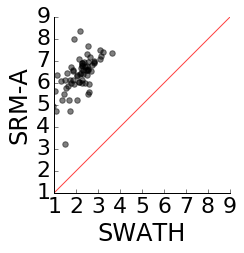

In [26]:
sys.stdout.write("Correlation of the uncalibrated SWATH versus SRM-A values.\n")
uncalibrated_swathsrmA_df = joint_pivot_table(swath_df, srmA_1_df, 'Total Area Fragment')
swathsrmA_uncal = plot_correlation(uncalibrated_swathsrmA_df['shock_swath'], uncalibrated_swathsrmA_df['sample_srmA1'], 
                                   'SWATH', 'SRM-A')
#swathsrmA_uncal.savefig(os.path.join(project_dir, "osmotic_shock/results/swathsrmA_uncal.png"))

Correlation of the calibrated SWATH versus SRM-A values.
Finite precursors shared: 55


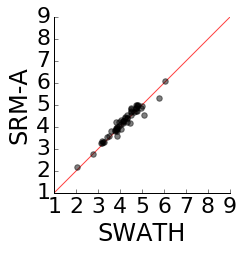

In [27]:
sys.stdout.write("Correlation of the calibrated SWATH versus SRM-A values.\n")
calibrated_swathsrmA_df = joint_pivot_table(calibrated_swath_df, calibrated_srmA_1_df, 'protein_copiespercell')
swathsrmA_cal = plot_correlation(calibrated_swathsrmA_df['shock_swath'], calibrated_swathsrmA_df['sample_srmA1'], 
                                 'SWATH', 'SRM-A')
#swathsrmA_cal.savefig(os.path.join(project_dir, "osmotic_shock/results/swathsrmA_cal.png"))

<a id = 'offsets'></a>
## Barchart of perpendicular offsets before and after calibration

We need a measure of how much better calibration does in getting the points closer to a line of equality, y=x. R^2, as shown above, doesn't do a good job of comparing how close a point is to y=x, because it only measures one dimension.


### On perpendicular offsets...
_from Wikipedia: "Distance of a point from a line"_

Given a line passing through two points, $P_{1}=(x_{1},y_{1})$ and $P_{2}=(x_{2},y_{2})$, then the distance of $(x_{0}, y_{0})$ to the line is:

$$ distance(P_{1},P_{2},(x_{0}, y_{0}))=\frac{|(y_{2}-y_{1})x_{0}-(x_{2}-x_{1})y_{0}+x_{2}y_{1}-y_{2}x_{1}|}{\sqrt{(y_{2}-y_{1})^2+(x_{2}-x_{1})^2}}$$

In this particular case, my line is $y=x$, so $y_{1}=x_{1}$ and $y_{2}=x_{2}$.

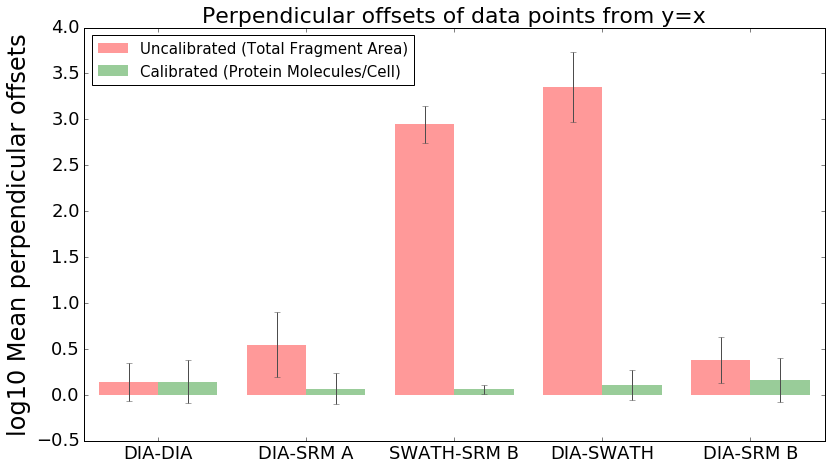

In [28]:
n_groups = 5

means_uncal = (np.mean(perpendicular_offset(uncalibrated_dia1dia2_df['sample_dia1'], 
                                            uncalibrated_dia1dia2_df['sample_dia2'])),
               np.mean(perpendicular_offset(uncalibrated_diaAsrmA_df['sample_dia1'], 
                                            uncalibrated_diaAsrmA_df['sample_srmA1'])),
               np.mean(perpendicular_offset(swathsrmB_uncalibrated_df ['shock_swath'], 
                                            swathsrmB_uncalibrated_df ['shock_srmB'])),
               np.mean(perpendicular_offset(uncalibrated_diaswath_df['sample_dia1'], 
                                            uncalibrated_diaswath_df['shock_swath'])),
               np.mean(perpendicular_offset(uncalibrated_diasrmB_df['sample_dia1'], 
                                            uncalibrated_diasrmB_df['shock_srmB'])))

std_uncal = (np.std(perpendicular_offset(uncalibrated_dia1dia2_df['sample_dia1'], 
                                         uncalibrated_dia1dia2_df['sample_dia2'])),
             np.std(perpendicular_offset(uncalibrated_diaAsrmA_df['sample_dia1'], 
                                         uncalibrated_diaAsrmA_df['sample_srmA1'])),
             np.std(perpendicular_offset(swathsrmB_uncalibrated_df ['shock_swath'], 
                                         swathsrmB_uncalibrated_df ['shock_srmB'])),
             np.std(perpendicular_offset(uncalibrated_diaswath_df['sample_dia1'], 
                                         uncalibrated_diaswath_df['shock_swath'])),
             np.std(perpendicular_offset(uncalibrated_diasrmB_df['sample_dia1'], 
                                         uncalibrated_diasrmB_df['shock_srmB'])))

means_cal = (np.mean(perpendicular_offset(calibrated_dia1dia2_df['sample_dia1'], 
                                          calibrated_dia1dia2_df['sample_dia2'])),
             np.mean(perpendicular_offset(calibrated_diaAsrmA_df['sample_dia1'], 
                                          calibrated_diaAsrmA_df['sample_srmA1'])),
             np.mean(perpendicular_offset(swathsrmB_calibrated_df ['shock_swath'], 
                                          swathsrmB_calibrated_df ['shock_srmB'])),
             np.mean(perpendicular_offset(calibrated_diaswath_df['sample_dia1'], 
                                          calibrated_diaswath_df['shock_swath'])),
             np.mean(perpendicular_offset(calibrated_diasrmB_df['sample_dia1'], 
                                          calibrated_diasrmB_df['shock_srmB'])))

std_cal = (np.std(perpendicular_offset(calibrated_dia1dia2_df['sample_dia1'], 
                                       calibrated_dia1dia2_df['sample_dia2'])),
             np.std(perpendicular_offset(calibrated_diaAsrmA_df['sample_dia1'], 
                                         calibrated_diaAsrmA_df['sample_srmA1'])),
             np.std(perpendicular_offset(swathsrmB_calibrated_df ['shock_swath'], 
                                         swathsrmB_calibrated_df ['shock_srmB'])),
             np.std(perpendicular_offset(calibrated_diaswath_df['sample_dia1'], 
                                         calibrated_diaswath_df['shock_swath'])),
             np.std(perpendicular_offset(calibrated_diasrmB_df['sample_dia1'], 
                                         calibrated_diasrmB_df['shock_srmB'])))

fig, ax = plt.subplots(figsize=(12, 7))

index = np.arange(n_groups)
bar_width = 0.4

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index + 0.1, means_uncal, bar_width,
                alpha=opacity, color='r', linewidth=0,
                yerr=std_uncal, error_kw=error_config,
                label='Uncalibrated (Total Fragment Area)')

rects2 = ax.bar(index + bar_width + 0.1, means_cal, bar_width,
                alpha=opacity, color='g', linewidth=0,
                yerr=std_cal, error_kw=error_config,
                label='Calibrated (Protein Molecules/Cell)')

ax.set_ylabel('log10 Mean perpendicular offsets')
ax.set_title('Perpendicular offsets of data points from y=x')
ax.set_xticks(index + bar_width + 0.1)
ax.set_xticklabels(('DIA-DIA', 'DIA-SRM A', 'SWATH-SRM B', 'DIA-SWATH', 'DIA-SRM B'))
ax.tick_params(labelsize=18)
ax.legend(loc=2, prop={'size': 15})

fig.tight_layout()

#plt.savefig(os.path.join(project_dir, "osmotic_shock/results/perp_offset_barchart.png"))